# Задание 1: Сравнение CNN и полносвязных сетей

## 1.1. Сравнение на MNIST

### Импорт библиотек 

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms.v2 as v2
import time
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

### Подготовка данных

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
epochs = 15
lr = 0.001

transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Создание моделей

#### Полносвязная нейронная сеть

In [21]:
class FCN(nn.Module):
    def __init__(self, input_size=784, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.25) # Небольшая регуляризация
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

#### Простая CNN (взял из репозитория HW4)

In [22]:
class SimpleCNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

#### CNN c Residual Block (взял из репозитория HW4)

In [23]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class CNNWithResidual(nn.Module):
    def __init__(self, input_channels=1, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.res1 = ResidualBlock(32, 32)
        self.res2 = ResidualBlock(32, 64, 2)
        self.res3 = ResidualBlock(64, 64)
        
        self.pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc = nn.Linear(64 * 4 * 4, num_classes)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

### Функция для обучения

In [24]:
def train_model(model, optimizer, criterion, train_loader, val_loader, epochs):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0, 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            y_pred = model(data)
            loss = criterion(y_pred, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pred = y_pred.argmax(dim=1)
            train_correct += pred.eq(target).sum().item()
        

        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                y_pred = model(data)
                val_loss += criterion(y_pred, target).item()
                pred = y_pred.argmax(dim=1)
                val_correct += pred.eq(target).sum().item()
        

        train_loss /= len(train_loader)
        train_acc = 100. * train_correct / len(train_loader.dataset)
        val_loss /= len(val_loader)
        val_acc = 100. * val_correct / len(val_loader.dataset)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%')

    train_time = time.time() - start_time
    return history, train_time

# Функция для измерения времени на обработку одного батча для каждой модели
# для оценки производительности
def measure_inference_time(model, val_loader):
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for data, _ in val_loader:
            data = data.to(device)
            _ = model(data)
    return (time.time() - start_time) / len(val_loader)

### Функции для визуализации

In [25]:
def plot_loss_accuracy(history):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Тренировочная Loss')
    plt.plot(history['val_loss'], label='Валидационная Loss')
    plt.title(f'{name} Кривые Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Тренировочная точность')
    plt.plot(history['val_acc'], label='Валидационная точность')
    plt.title(f'{name} Кривые Точности')
    plt.legend()
    plt.savefig(f"plots/{name}_curves_task_1.jpg")
    plt.show()

def plot_for_analysis(name_models, parameters):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    plt.subplots_adjust(hspace=0.3)

    axs[0, 0].bar(
        name_models, 
        parameters['count_parameters'],
        color = ['red', 'green', 'blue'],
        edgecolor='black'
    )
    axs[0, 0].set_title('Количество параметров моделей')
    axs[0, 0].set_xlabel('Модель')
    axs[0, 0].set_ylabel('Количество параметров')

    axs[0, 1].bar(
        name_models,
        parameters['time_train'],
        color=['orange', 'green', 'yellow'],
        edgecolor='black'
    )
    axs[0, 1].set_title('Время обучения')
    axs[0, 1].set_xlabel('Модель')
    axs[0, 1].set_ylabel('Время (сек)')
    

    axs[1, 0].bar(
        name_models,
        parameters['inf_time'],
        color=['red', 'green', 'blue'],
        edgecolor='black'
    )
    axs[1, 0].set_title('Количество времени на один батч')
    axs[1, 0].set_xlabel('Модель')
    axs[1, 0].set_ylabel('Время (мс)')

    axs[1, 1].bar(
        name_models,
        parameters['accuracy'],
        color=['orange', 'green', 'yellow'],
        edgecolor='black'
    )
    axs[1, 1].set_title('Точность')
    axs[1, 1].set_xlabel('Модель')
    axs[1, 1].set_ylabel('Точность (%)')
    

    plt.show()
    plt.savefig("plots/comparasion_model_parameters_task_1.jpg")

### Обучение модели


=== Обучение модели FCN ===
Epoch 1/15 | Train Loss: 0.2838 | Val Loss: 0.1153 | Train Acc: 91.32% | Val Acc: 96.48%
Epoch 2/15 | Train Loss: 0.1395 | Val Loss: 0.1062 | Train Acc: 95.85% | Val Acc: 96.71%
Epoch 3/15 | Train Loss: 0.1077 | Val Loss: 0.0904 | Train Acc: 96.85% | Val Acc: 97.35%
Epoch 4/15 | Train Loss: 0.0901 | Val Loss: 0.0861 | Train Acc: 97.24% | Val Acc: 97.47%
Epoch 5/15 | Train Loss: 0.0821 | Val Loss: 0.0723 | Train Acc: 97.60% | Val Acc: 97.85%
Epoch 6/15 | Train Loss: 0.0733 | Val Loss: 0.0657 | Train Acc: 97.80% | Val Acc: 98.12%
Epoch 7/15 | Train Loss: 0.0689 | Val Loss: 0.0665 | Train Acc: 97.94% | Val Acc: 98.05%
Epoch 8/15 | Train Loss: 0.0633 | Val Loss: 0.0751 | Train Acc: 98.08% | Val Acc: 97.90%
Epoch 9/15 | Train Loss: 0.0569 | Val Loss: 0.0752 | Train Acc: 98.25% | Val Acc: 97.93%
Epoch 10/15 | Train Loss: 0.0565 | Val Loss: 0.0775 | Train Acc: 98.32% | Val Acc: 98.03%
Epoch 11/15 | Train Loss: 0.0509 | Val Loss: 0.0695 | Train Acc: 98.41% | Val Ac

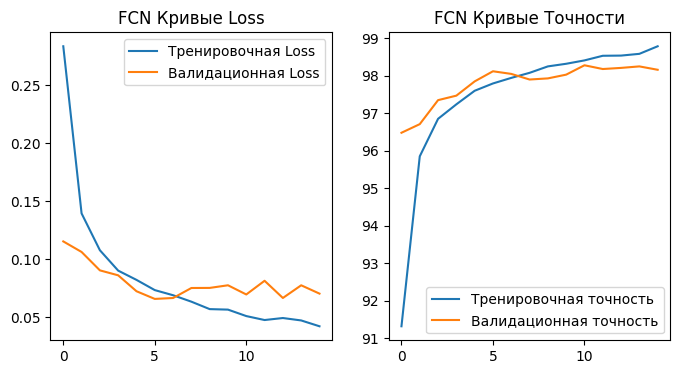


=== Обучение модели SimpleCNN ===
Epoch 1/15 | Train Loss: 0.1731 | Val Loss: 0.0467 | Train Acc: 94.69% | Val Acc: 98.47%
Epoch 2/15 | Train Loss: 0.0555 | Val Loss: 0.0294 | Train Acc: 98.32% | Val Acc: 99.03%
Epoch 3/15 | Train Loss: 0.0405 | Val Loss: 0.0266 | Train Acc: 98.77% | Val Acc: 99.20%
Epoch 4/15 | Train Loss: 0.0292 | Val Loss: 0.0251 | Train Acc: 99.12% | Val Acc: 99.17%
Epoch 5/15 | Train Loss: 0.0256 | Val Loss: 0.0289 | Train Acc: 99.18% | Val Acc: 99.14%
Epoch 6/15 | Train Loss: 0.0210 | Val Loss: 0.0214 | Train Acc: 99.30% | Val Acc: 99.34%
Epoch 7/15 | Train Loss: 0.0172 | Val Loss: 0.0265 | Train Acc: 99.43% | Val Acc: 99.18%
Epoch 8/15 | Train Loss: 0.0156 | Val Loss: 0.0332 | Train Acc: 99.48% | Val Acc: 99.19%
Epoch 9/15 | Train Loss: 0.0136 | Val Loss: 0.0273 | Train Acc: 99.53% | Val Acc: 99.19%
Epoch 10/15 | Train Loss: 0.0108 | Val Loss: 0.0399 | Train Acc: 99.61% | Val Acc: 98.97%
Epoch 11/15 | Train Loss: 0.0129 | Val Loss: 0.0259 | Train Acc: 99.55% | 

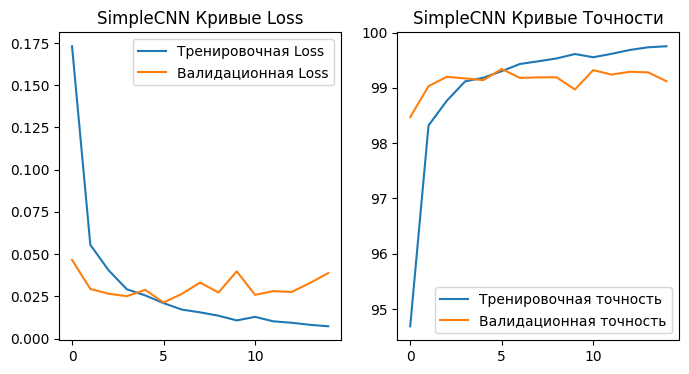


=== Обучение модели CNNWithResidual ===
Epoch 1/15 | Train Loss: 0.1028 | Val Loss: 0.0332 | Train Acc: 97.01% | Val Acc: 98.88%
Epoch 2/15 | Train Loss: 0.0392 | Val Loss: 0.0400 | Train Acc: 98.79% | Val Acc: 98.77%
Epoch 3/15 | Train Loss: 0.0306 | Val Loss: 0.0174 | Train Acc: 99.02% | Val Acc: 99.42%
Epoch 4/15 | Train Loss: 0.0255 | Val Loss: 0.0218 | Train Acc: 99.20% | Val Acc: 99.26%
Epoch 5/15 | Train Loss: 0.0211 | Val Loss: 0.0174 | Train Acc: 99.33% | Val Acc: 99.45%
Epoch 6/15 | Train Loss: 0.0206 | Val Loss: 0.0234 | Train Acc: 99.35% | Val Acc: 99.24%
Epoch 7/15 | Train Loss: 0.0173 | Val Loss: 0.0249 | Train Acc: 99.46% | Val Acc: 99.17%
Epoch 8/15 | Train Loss: 0.0138 | Val Loss: 0.0242 | Train Acc: 99.55% | Val Acc: 99.26%
Epoch 9/15 | Train Loss: 0.0140 | Val Loss: 0.0216 | Train Acc: 99.53% | Val Acc: 99.26%
Epoch 10/15 | Train Loss: 0.0108 | Val Loss: 0.0170 | Train Acc: 99.66% | Val Acc: 99.51%
Epoch 11/15 | Train Loss: 0.0094 | Val Loss: 0.0176 | Train Acc: 99.

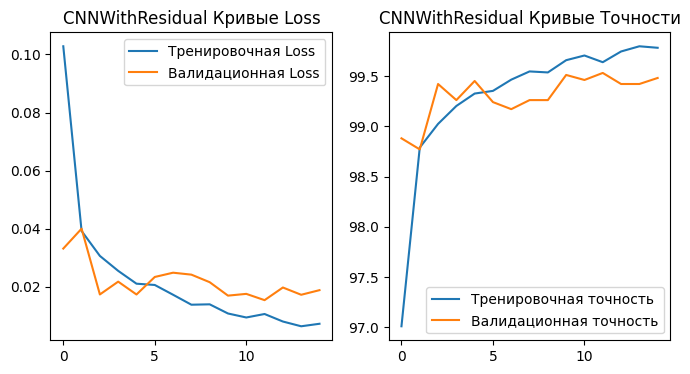

In [26]:
models = {
    "FCN": FCN().to(device),
    "SimpleCNN": SimpleCNN().to(device),
    "CNNWithResidual": CNNWithResidual().to(device)
}
    
results = {}
criterion = nn.CrossEntropyLoss()

for name, model in models.items():
    print(f"\n=== Обучение модели {name} ===")
    optimizer = optim.Adam(model.parameters(), lr=lr)
    history, train_time = train_model(
        model, optimizer, criterion, 
        train_loader, val_loader, epochs
    )
    inf_time = measure_inference_time(model, val_loader)
    num_params = sum(p.numel() for p in model.parameters())
    
    results[name] = {
        "history": history,
        "train_time": train_time,
        "inf_time": inf_time,
        "params": num_params
    }
    
    plot_loss_accuracy(history)

### Анализ результатов


=== Сравнение моделей ===
FCN:
  Параметры: 567,434
  Время обучения: 340.67 сек
  Время обработки одного батча (инференс): 16.51 мс/батч
  Точность: 98.16%

SimpleCNN:
  Параметры: 421,642
  Время обучения: 352.38 сек
  Время обработки одного батча (инференс): 17.09 мс/батч
  Точность: 99.12%

CNNWithResidual:
  Параметры: 160,906
  Время обучения: 430.24 сек
  Время обработки одного батча (инференс): 16.47 мс/батч
  Точность: 99.48%



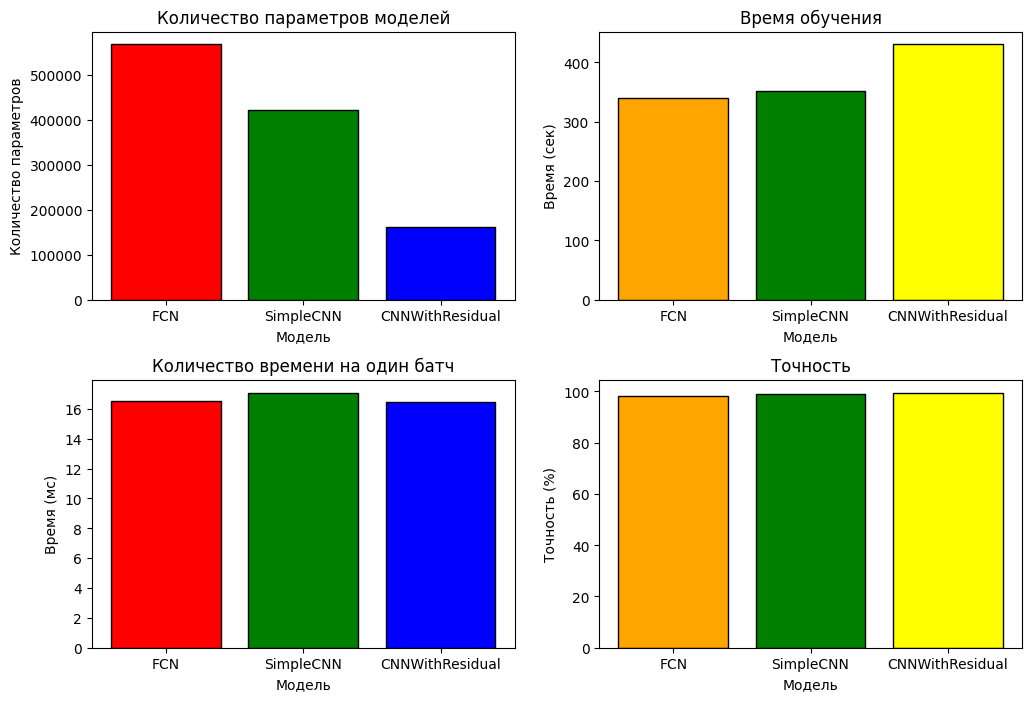

<Figure size 640x480 with 0 Axes>

In [27]:
# Анализ результатов
print("\n=== Сравнение моделей ===")
for name, res in results.items():
    last_acc = res['history']['val_acc'][-1]
    print(f"{name}:")
    print(f"  Параметры: {res['params']:,}")
    print(f"  Время обучения: {res['train_time']:.2f} сек")
    print(f"  Время обработки одного батча (инференс): {res['inf_time'] * 1000:.2f} мс/батч")
    print(f"  Точность: {last_acc:.2f}%\n")

# Визуализация разных параметров
name_models = [name for name in results]
data_for_visual = {}

count_parameters = [res['params'] for _, res in results.items()]
time_train = [res['train_time'] for _, res in results.items()]
inf_time = [res['inf_time'] * 1000 for _, res in results.items()]
accuracy = [res['history']['val_acc'][-1] for _, res in results.items()]

data_for_visual['count_parameters'] = count_parameters
data_for_visual['time_train'] = time_train
data_for_visual['inf_time'] = inf_time
data_for_visual['accuracy'] = accuracy

plot_for_analysis(name_models, data_for_visual)

## 1.2. Сравнение на CIFAR-10

### Импорт библиотек

In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms.v2 as v2
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Подготовка данных

In [97]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
epochs = 15
lr = 0.01

# Загрузка датасета CIFAR-10
transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

train_dataset_cifar = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
val_dataset_cifar = datasets.CIFAR10('./data', train=False, download=True, transform=transform)

train_loader_cifar = DataLoader(train_dataset_cifar, batch_size=batch_size, shuffle=True)
val_loader_cifar = DataLoader(val_dataset_cifar, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### Модели

#### Полносвязная сеть (взял из репозитория)

In [98]:
class CIFARCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

#### CNN (с регуляризацией и без, зависит от параметра use_reg)

In [99]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class CNNWithResidual(nn.Module):
    def __init__(self, input_channels=3, use_reg=False, num_classes=10):
        super().__init__()
        self.use_reg = use_reg
        
        self.conv1 = nn.Conv2d(input_channels, 32, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.layer1 = self._make_layer(32, 32, 2, stride=1)
        self.layer2 = self._make_layer(32, 64, 2, stride=2)
        self.layer3 = self._make_layer(64, 128, 2, stride=2)
        self.layer4 = self._make_layer(128, 256, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        if use_reg:
            self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256, num_classes)
    
    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, 1))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        if self.use_reg:
            x = self.dropout(x)
        x = self.fc(x)
        return x

### Функция обучения

In [100]:
def train_model(model, optimizer, criterion, train_loader, val_loader, epochs):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    gradient_flow = {name: [] for name, _ in model.named_parameters() if 'weight' in name}
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0, 0
        
        # Запись градиентов
        hooks = []
        for name, param in model.named_parameters():
            if 'weight' in name and param.requires_grad:
                hook = param.register_hook(
                    lambda grad, name=name: gradient_flow[name].append(grad.abs().mean().item())
                )
                hooks.append(hook)
        
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            y_pred = model(data)
            loss = criterion(y_pred, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            pred = y_pred.argmax(dim=1)
            train_correct += pred.eq(target).sum().item()
        
        # Удаление hook
        for hook in hooks:
            hook.remove()
        
        model.eval()
        val_loss, val_correct = 0, 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                y_pred = model(data)
                val_loss += criterion(y_pred, target).item()
                pred = y_pred.argmax(dim=1)
                val_correct += pred.eq(target).sum().item()
                all_preds.extend(pred.cpu().numpy())
                all_targets.extend(target.cpu().numpy())
        
        train_loss /= len(train_loader)
        train_acc = 100. * train_correct / len(train_loader.dataset)
        val_loss /= len(val_loader)
        val_acc = 100. * val_correct / len(val_loader.dataset)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch+1}/{epochs} | '
              f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | '
              f'Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%')
    
    train_time = time.time() - start_time
    return history, train_time, gradient_flow, (all_preds, all_targets)

### Функции визуализация

In [101]:
def plot_confusion_matrix(model_name, preds, targets, class_names):
    """
    Функция для создания confusion matrix
    """
    cm = confusion_matrix(targets, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Предсказанные знач.')
    plt.ylabel('Истинные знач.')
    plt.title(f'Confusion Matrix модели {model_name}')
    plt.savefig(f'plots/{model_name}_confusion_matrix_task_1_2.jpg')
    plt.show()

def plot_gradient_flow(model_name, gradient_flow):
    """Функция визуализации градиентов"""
    plt.figure(figsize=(12, 6))
    for name, grad in gradient_flow.items():
        plt.plot(grad, label=name)
    plt.yscale('log')
    plt.xlabel('Итерация')
    plt.ylabel('Средняя величина градиента (log scale)')
    plt.title(f'Градиентный поток во время обучения модели {model_name}')
    plt.legend()
    plt.savefig(f'plots/{model_name}_gradient_flow_task_1_2.jpg')
    plt.show()

def plot_loss_accuracy(model_name, history):
    """Функция визуализация кривых точности и функции потерь"""
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Кривые Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.title(f'{model_name} Кривые метрики Точности')
    plt.legend()
    plt.savefig(f'plots/{model_name}_curves_task_1_2.jpg')
    plt.show()

### Обучение


=== Обучение модели CIFARCNN ===
Epoch 1/15 | Train Loss: 1.7812 | Val Loss: 1.4089 | Train Acc: 34.46% | Val Acc: 49.11%
Epoch 2/15 | Train Loss: 1.2895 | Val Loss: 1.1177 | Train Acc: 53.64% | Val Acc: 59.61%
Epoch 3/15 | Train Loss: 1.0551 | Val Loss: 0.9599 | Train Acc: 62.52% | Val Acc: 65.90%
Epoch 4/15 | Train Loss: 0.9016 | Val Loss: 0.8512 | Train Acc: 68.43% | Val Acc: 70.33%
Epoch 5/15 | Train Loss: 0.7935 | Val Loss: 0.8486 | Train Acc: 72.07% | Val Acc: 70.25%
Epoch 6/15 | Train Loss: 0.7006 | Val Loss: 0.7744 | Train Acc: 75.54% | Val Acc: 73.21%
Epoch 7/15 | Train Loss: 0.6270 | Val Loss: 0.7238 | Train Acc: 78.05% | Val Acc: 74.93%
Epoch 8/15 | Train Loss: 0.5543 | Val Loss: 0.7235 | Train Acc: 80.48% | Val Acc: 75.76%
Epoch 9/15 | Train Loss: 0.4925 | Val Loss: 0.7260 | Train Acc: 82.59% | Val Acc: 75.68%
Epoch 10/15 | Train Loss: 0.4346 | Val Loss: 0.6957 | Train Acc: 84.56% | Val Acc: 77.34%
Epoch 11/15 | Train Loss: 0.3714 | Val Loss: 0.7613 | Train Acc: 86.86% | V

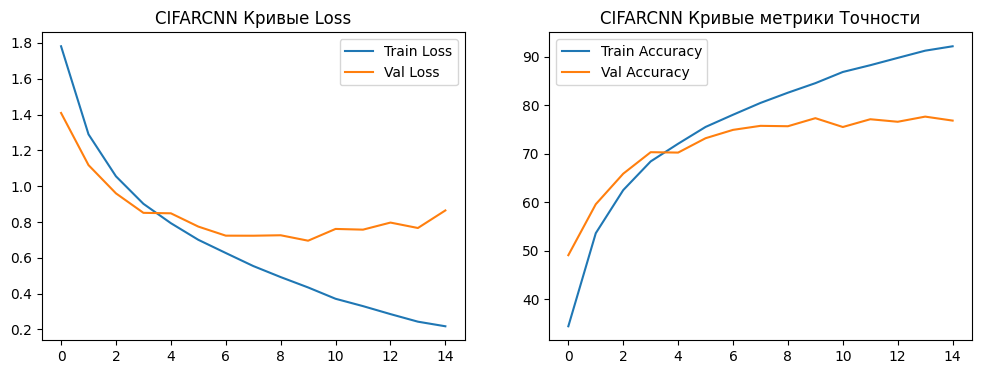

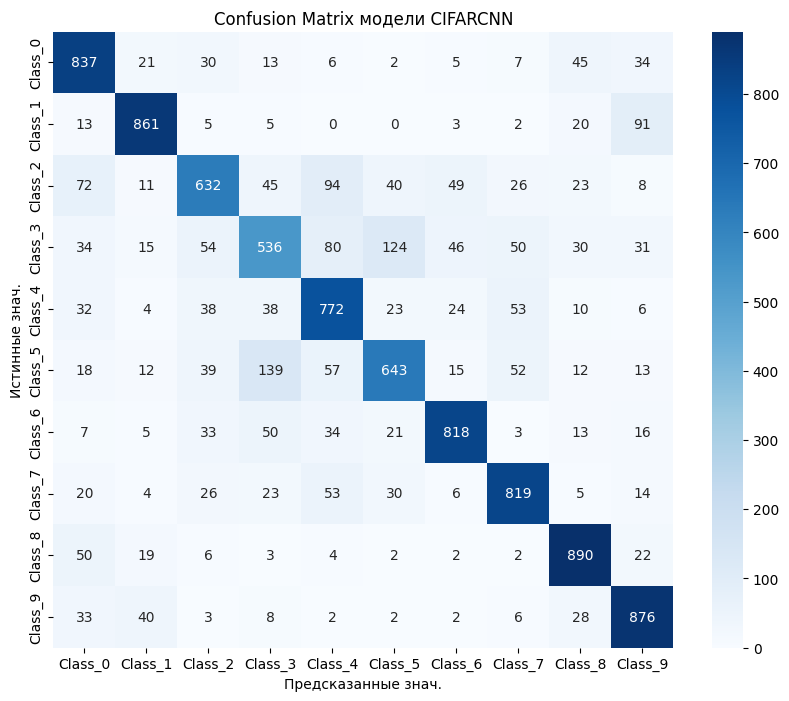

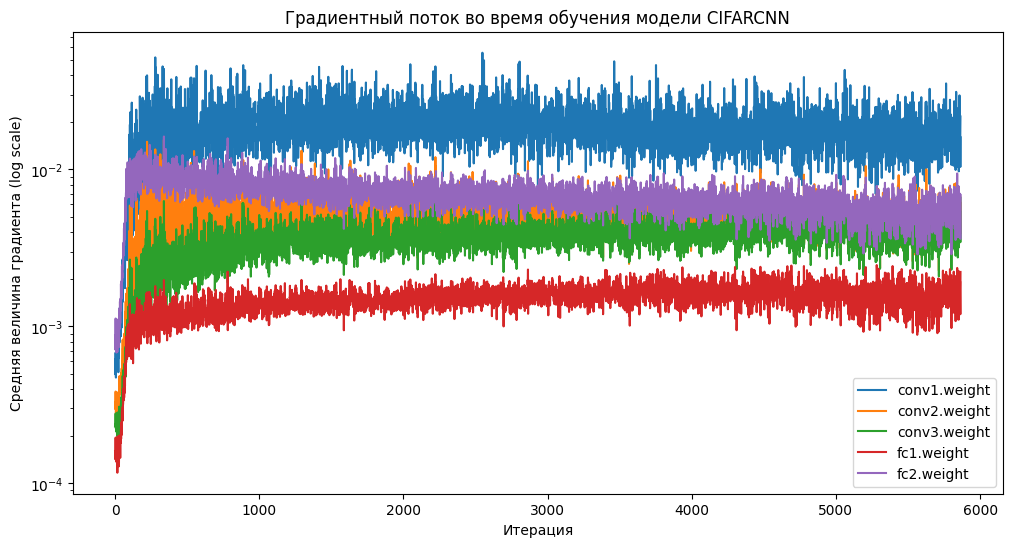


=== Обучение модели CNN ===
Epoch 1/15 | Train Loss: 1.3049 | Val Loss: 1.0601 | Train Acc: 52.48% | Val Acc: 62.80%
Epoch 2/15 | Train Loss: 0.7980 | Val Loss: 0.8233 | Train Acc: 71.87% | Val Acc: 71.22%
Epoch 3/15 | Train Loss: 0.5854 | Val Loss: 0.7943 | Train Acc: 79.50% | Val Acc: 73.27%
Epoch 4/15 | Train Loss: 0.4444 | Val Loss: 0.7364 | Train Acc: 84.44% | Val Acc: 76.34%
Epoch 5/15 | Train Loss: 0.3306 | Val Loss: 0.7708 | Train Acc: 88.54% | Val Acc: 77.02%
Epoch 6/15 | Train Loss: 0.2367 | Val Loss: 0.8086 | Train Acc: 91.68% | Val Acc: 77.09%
Epoch 7/15 | Train Loss: 0.1643 | Val Loss: 0.9034 | Train Acc: 94.24% | Val Acc: 76.93%
Epoch 8/15 | Train Loss: 0.1200 | Val Loss: 0.8462 | Train Acc: 95.75% | Val Acc: 78.33%
Epoch 9/15 | Train Loss: 0.0816 | Val Loss: 0.8619 | Train Acc: 97.22% | Val Acc: 79.43%
Epoch 10/15 | Train Loss: 0.0656 | Val Loss: 1.2110 | Train Acc: 97.78% | Val Acc: 75.23%
Epoch 11/15 | Train Loss: 0.0498 | Val Loss: 0.9580 | Train Acc: 98.34% | Val Ac

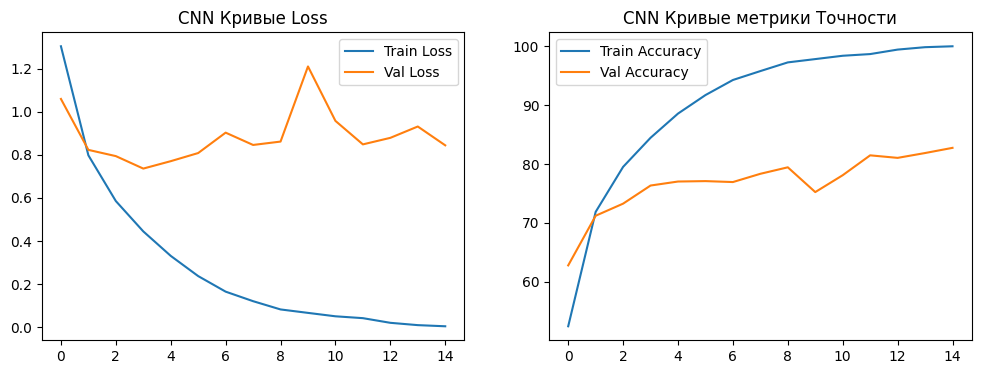

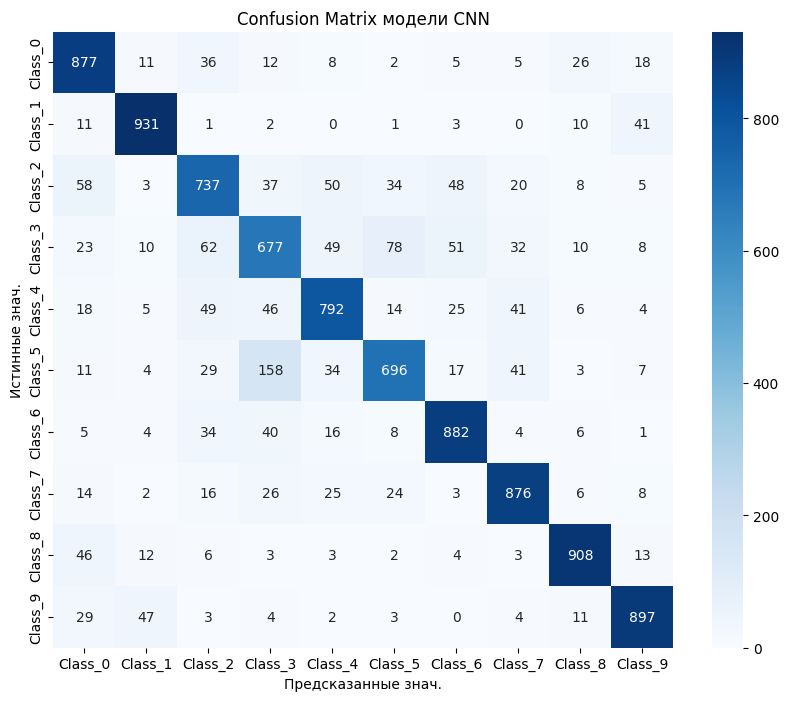

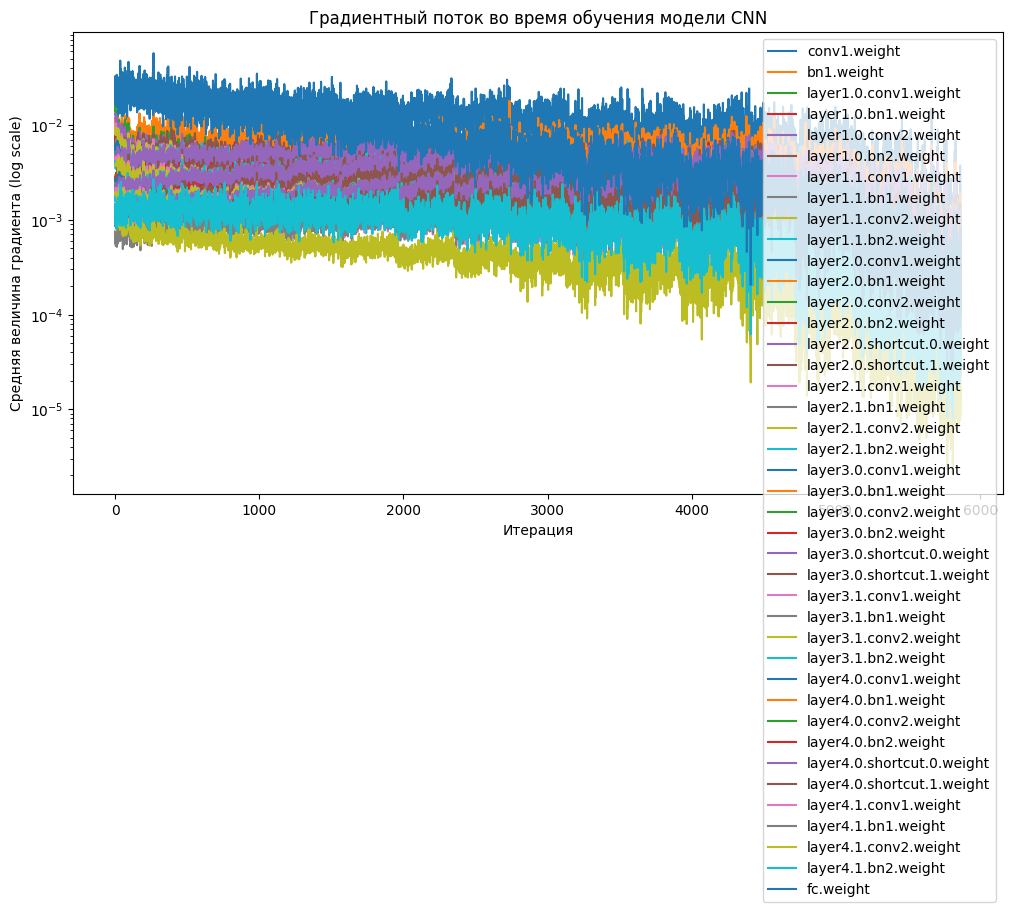


=== Обучение модели CNN-Regularized ===
Epoch 1/15 | Train Loss: 1.4967 | Val Loss: 1.1766 | Train Acc: 44.93% | Val Acc: 58.65%
Epoch 2/15 | Train Loss: 0.9759 | Val Loss: 1.3005 | Train Acc: 65.78% | Val Acc: 53.15%
Epoch 3/15 | Train Loss: 0.7727 | Val Loss: 0.9195 | Train Acc: 73.59% | Val Acc: 68.59%
Epoch 4/15 | Train Loss: 0.6758 | Val Loss: 0.7422 | Train Acc: 77.54% | Val Acc: 74.64%
Epoch 5/15 | Train Loss: 0.6227 | Val Loss: 0.8581 | Train Acc: 79.47% | Val Acc: 71.15%
Epoch 6/15 | Train Loss: 0.5955 | Val Loss: 0.6723 | Train Acc: 80.66% | Val Acc: 77.64%
Epoch 7/15 | Train Loss: 0.5762 | Val Loss: 0.7217 | Train Acc: 81.37% | Val Acc: 75.90%
Epoch 8/15 | Train Loss: 0.5638 | Val Loss: 1.1234 | Train Acc: 81.85% | Val Acc: 61.80%
Epoch 9/15 | Train Loss: 0.5433 | Val Loss: 0.9707 | Train Acc: 82.63% | Val Acc: 66.95%
Epoch 10/15 | Train Loss: 0.5301 | Val Loss: 1.0054 | Train Acc: 82.88% | Val Acc: 66.90%
Epoch 11/15 | Train Loss: 0.5260 | Val Loss: 0.7011 | Train Acc: 83.

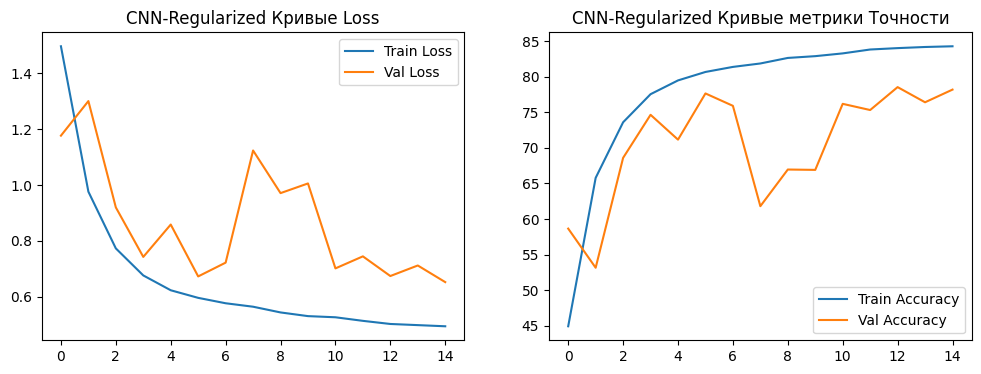

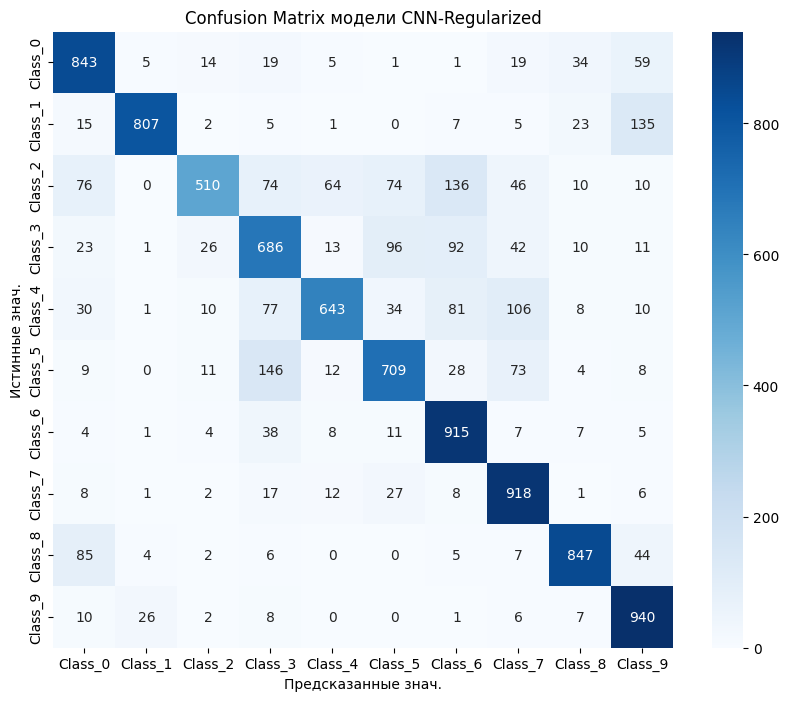

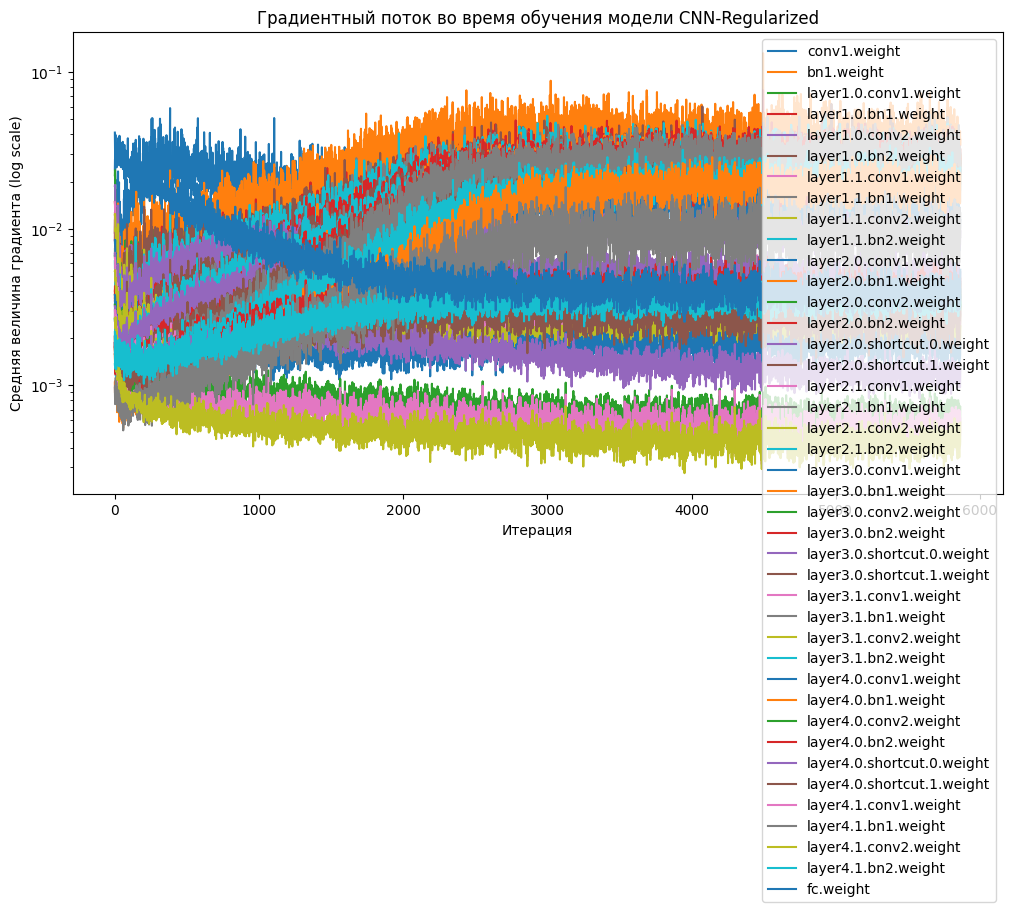

In [102]:
class_names = [f'Class_{i}' for i in range(10)]
    
models_cifar = {
    "CIFARCNN": CIFARCNN().to(device),
    "CNN": CNNWithResidual().to(device),
    "CNN-Regularized": CNNWithResidual(use_reg=True).to(device)
} 

results = {}
criterion = nn.CrossEntropyLoss()

for name, model in models_cifar.items():
    print(f"\n=== Обучение модели {name} ===")
    
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.01 if name == 'CNN-Regularized' else 0)
    
    history, train_time, grad_flow, cm_data = train_model(
        model, optimizer, criterion,
        train_loader_cifar, val_loader_cifar, epochs
    )
    
    results[name] = {
        "history": history,
        "train_time": train_time,
        "grad_flow": grad_flow,
        "cm_data": cm_data,
        "params": sum(p.numel() for p in model.parameters())
    }
    
    # Визуализация для каждой модели значений функции потерь и точности
    plot_loss_accuracy(name, history)
    
    # Матрица ошибок
    plot_confusion_matrix(name, *cm_data, class_names)
    
    # Градиенты
    plot_gradient_flow(name, grad_flow)